In [1]:
import os
import sys
sys.path.append("../")
from models.unet import UNetDiffusion, UNet_diffusion_normal, UNet_diffusion_sample, UNet_diffusion_mixednormal, UNet_diffusion_mvnormal
from data.datasets import PDE1D
import torch
from models.diffusion import Diffusion, generate_diffusion_samples_low_dimensional, DistributionalDiffusion
import matplotlib.pyplot as plt
import numpy as np

device = "cuda"

In [2]:
test_dataset = PDE1D(
    data_dir="../data/",
    pde="KS",
    var="test",
    downscaling_factor=2,
    normalize=True,
    last_t_steps=2,
    temporal_downscaling_factor=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=3,
    shuffle=True,
    num_workers=0,
)

target_dim, input_dim = (
    (1, *test_dataset.get_dimensions()),
    (3, *test_dataset.get_dimensions()),
)
grid = test_dataset.get_coordinates()[0]

In [3]:
cfg_scale = 0
x_T_sampling_method="standard"
n_timesteps = 50
n_samples = 25
t_steps = 10

In [4]:
def plot_predictions(input, target, pred, grid, last_t_timesteps = 2):
    fig, axs = plt.subplots(3, 3, figsize=(18, 8))

    input_last_t = input[:,last_t_timesteps-1].cpu()
    mean_prediction = pred[:,0].mean(axis = -1).cpu()
    pred = pred.cpu()
    target = target.cpu()
    for i in range(3):
        axs[i,0].plot(grid, input_last_t[i].numpy())

        for j in range(n_samples):
            axs[i,1].plot(grid, (pred[i,0,:,j]+input_last_t[i]).numpy(), alpha=0.2, color="grey")
        axs[i,1].plot(grid, (target[i,0]+input_last_t[i]).numpy())
        axs[i,1].plot(grid, (mean_prediction[i]+input_last_t[i]).numpy(), label="Mean prediction", linestyle = "dashed")
        axs[i,1].set_ylim([(mean_prediction[i]+input_last_t[i]).min()-0.2, (mean_prediction[i]+input_last_t[i]).max()+0.2])


        for j in range(n_samples):
            axs[i,2].plot(grid, pred[i,0,:,j].numpy(), alpha=0.2, color="grey")
        axs[i,2].plot(grid, target[i,0].numpy(), label = "Truth")
        axs[i,2].plot(grid, mean_prediction[i].numpy(), label="Mean prediction", linestyle = "dashed")
        #axs[i,2].set_ylim([mean_prediction[i].min()-0.2, mean_prediction[i].max()+0.2])

        axs[i,2].legend()


    axs[0,2].set_title("Residual prediction")
    axs[0,1].set_title("Original scale prediction")
    axs[0,0].set_title("Input")

In [5]:
# Batch to analyze
b = 0

# Deterministic

In [6]:
ckpt_path = "../results/20250716_085725_debug/Datetime_20250716_085725_Loss_1D_KS_UNet_diffusion_.pt"
distributional_method = "deterministic"

In [7]:
model =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim[-1]
        )
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)

/tmp/ipykernel_167931/1995388319.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [8]:
n_test = len(test_dataset)
indices = np.random.choice(n_test, 3, replace=False)
indices = np.array([357, 211, 833])
input = []
target = []
trajectory = []
for idx in indices:
    target_tensor, input_tensor = test_dataset.get_trajectory(idx)
    target_tensor = target_tensor.unsqueeze(0).to(device)
    input_tensor = input_tensor.unsqueeze(0).to(device)
    input.append(input_tensor)
    target.append(target_tensor[:,:,0]-input_tensor[:,-2])
    trajectory.append(target_tensor)
input = torch.cat(input, dim=0)
target = torch.cat(target, dim=0)
trajectory = torch.cat(trajectory, dim=0)

In [9]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps = n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
)

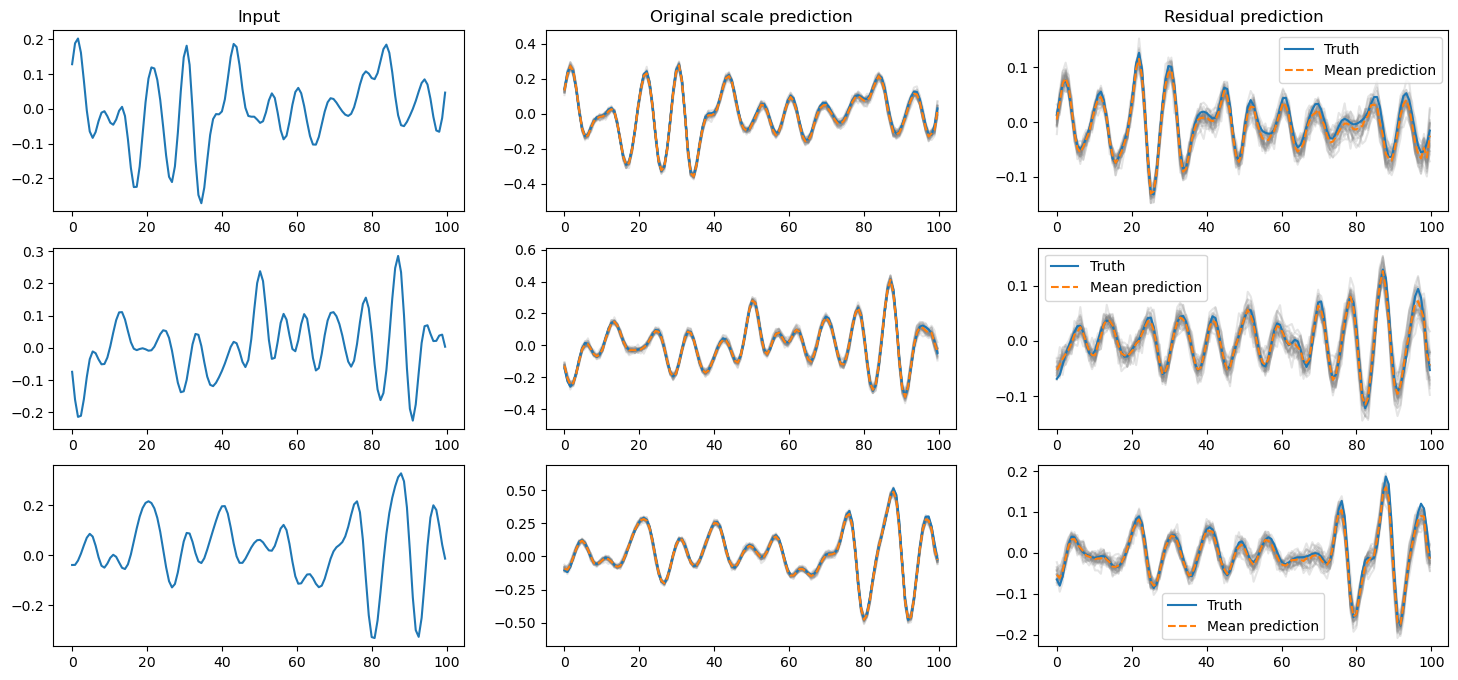

In [10]:
plot_predictions(input, target, pred, grid)

In [11]:
grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)

for i in range(n_samples):
    autoregressive_input = input.clone()
    pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
    for t in range(t_steps):
        pred = generate_diffusion_samples_low_dimensional(
            model=model,
            input = autoregressive_input,
            n_timesteps=n_timesteps,
            target_shape=target.shape,
            n_samples=1,
            distributional_method=distributional_method,
            x_T_sampling_method=x_T_sampling_method,
            cfg_scale=cfg_scale,
            noise_schedule="linear",
        )
        if t == 0:
            pred_array[...,t] = pred.squeeze(-1)+ t0
        else:
            pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

        if t == 1:
            autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
        elif t > 1:
            autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
    # Save
    full_array[...,i] = pred_array

Text(0, 0.5, 'Prediction')

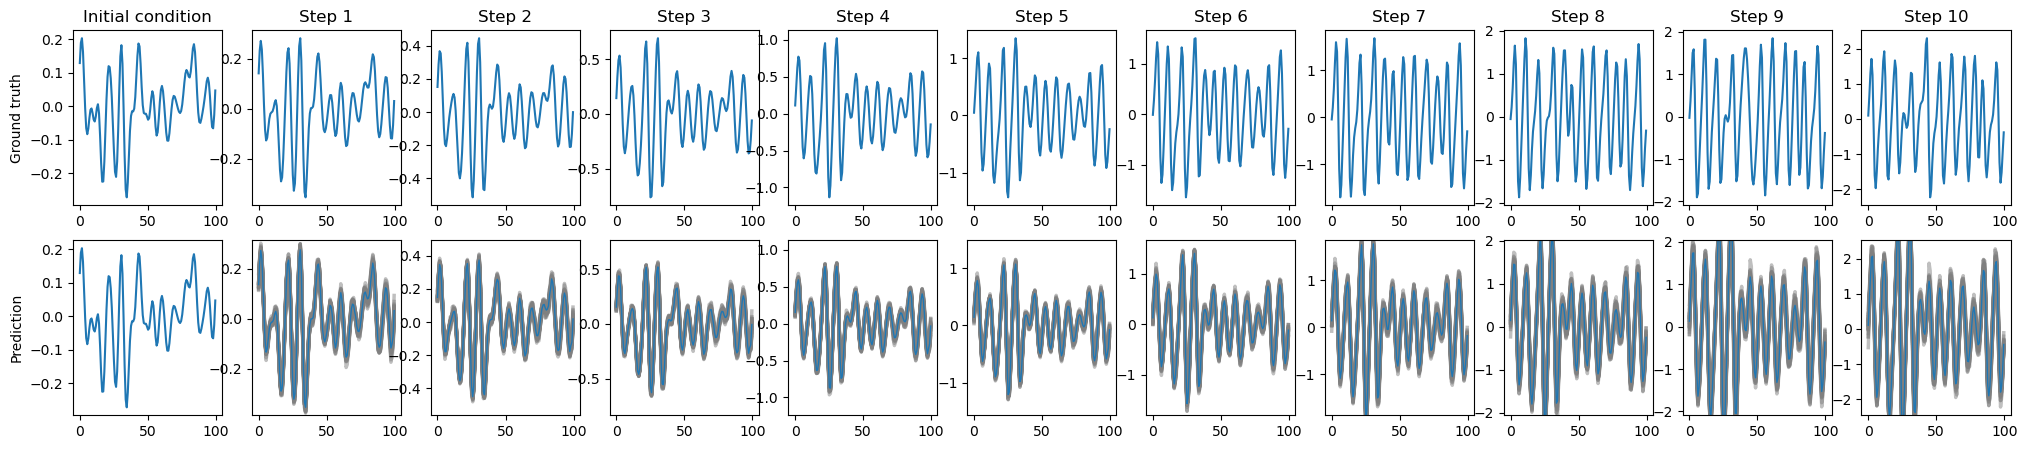

In [12]:
# Plot the autoregressive predictions
fig, axs = plt.subplots(2, t_steps+1, figsize=(25, 5))

# Truth
axs[0,0].plot(grid, t0[b,0].cpu().numpy())
axs[0,0].set_title("Initial condition")


axs[1,0].plot(grid, t0[b,0].cpu().numpy())
for t in range(t_steps):
    # Plot truth
    axs[0, t+1].plot(grid, trajectory[b,0,t].cpu().numpy(), label="Truth")
    axs[0,t+1].set_title(f"Step {t+1}")
    ylim = axs[0,t+1].get_ylim()

    for i in range(n_samples):
        pred_plot = full_array[b, 0, :, t, i]
        axs[1,t+1].plot(grid, pred_plot.cpu().numpy(), alpha=0.5, color="grey", lw = 2.5)
    # Plot mean
    pred_plot = full_array[b, 0, :, t].mean(axis=-1)
    axs[1,t+1].plot(grid, pred_plot.cpu().numpy(), label="Mean prediction", lw = 1)
    axs[1,t+1].set_ylim(ylim)



axs[0,0].set_ylabel("Ground truth")
axs[1,0].set_ylabel("Prediction")

In [13]:
trajectory[2,0,0]

tensor([-0.1043, -0.1191, -0.0792, -0.0101,  0.0603,  0.1094,  0.1231,  0.0991,
         0.0484, -0.0075, -0.0468, -0.0579, -0.0447, -0.0225, -0.0090, -0.0148,
        -0.0376, -0.0642, -0.0781, -0.0680, -0.0325,  0.0212,  0.0828,  0.1431,
         0.1969,  0.2420,  0.2757,  0.2912,  0.2767,  0.2207,  0.1221, -0.0015,
        -0.1168, -0.1903, -0.2043, -0.1623, -0.0829,  0.0084,  0.0865,  0.1307,
         0.1298,  0.0875,  0.0226, -0.0378, -0.0713, -0.0689, -0.0345,  0.0212,
         0.0872,  0.1543,  0.2131,  0.2523,  0.2588,  0.2238,  0.1504,  0.0577,
        -0.0261, -0.0770, -0.0855, -0.0583, -0.0113,  0.0378,  0.0739,  0.0878,
         0.0771,  0.0485,  0.0159, -0.0036,  0.0028,  0.0375,  0.0898,  0.1386,
         0.1592,  0.1343,  0.0657, -0.0237, -0.1006, -0.1405, -0.1406, -0.1175,
        -0.0948, -0.0893, -0.1034, -0.1255, -0.1389, -0.1310, -0.1007, -0.0572,
        -0.0152,  0.0128,  0.0225,  0.0211,  0.0256,  0.0556,  0.1226,  0.2188,
         0.3105,  0.3421,  0.2609,  0.06

# Normal

In [14]:
ckpt_path = "../results/20250716_083611_debug/Datetime_20250716_083611_Loss_1D_KS_UNet_diffusion_.pt"
distributional_method = "normal"

In [15]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim[-1]
        )

model = UNet_diffusion_normal(
    backbone=backbone,
    d=1,
    target_dim = 1,
)
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)


/tmp/ipykernel_167931/3274195715.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [16]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
)

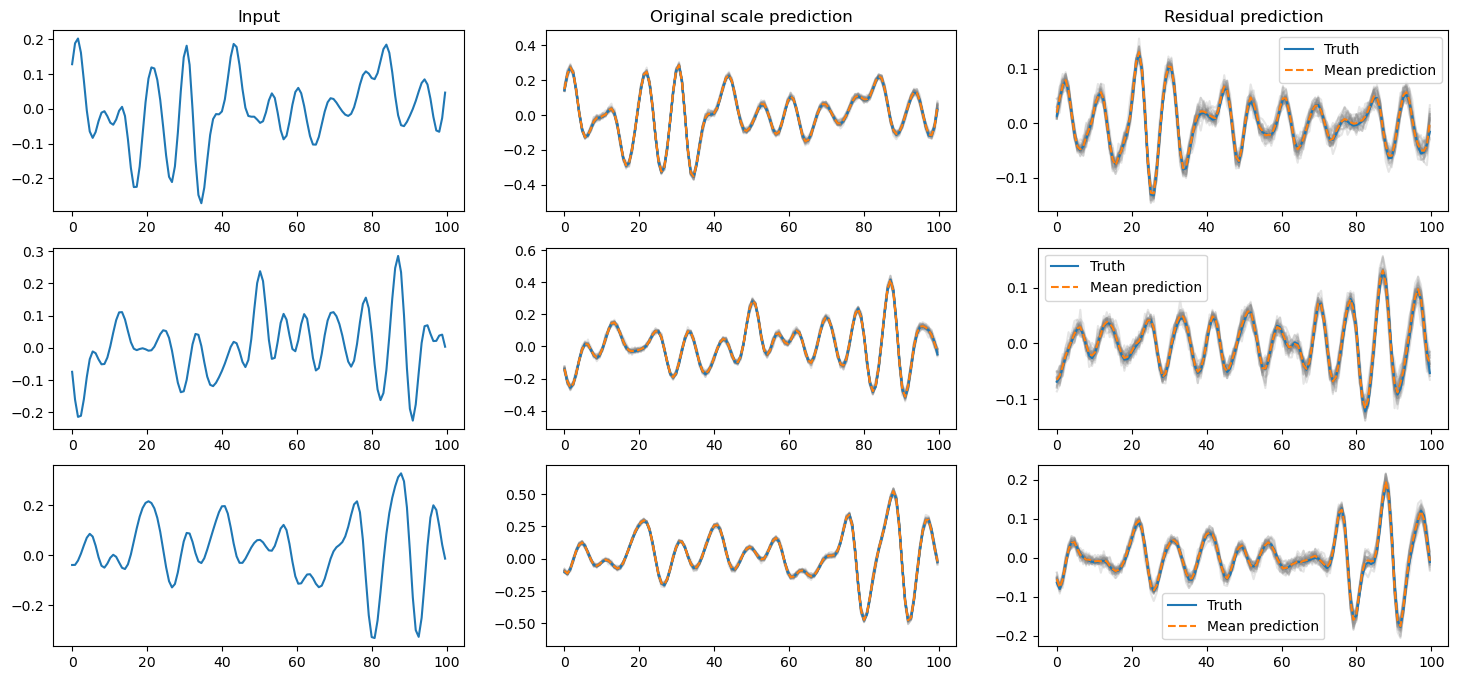

In [17]:
plot_predictions(input, target, pred, grid)

In [18]:
diffusion = DistributionalDiffusion(
    img_size=target.shape[1:], device=device, distributional_method=distributional_method, x_T_sampling_method=x_T_sampling_method
)
x = diffusion.sample_x_T((target.shape[0], *target_dim), pred)
t = (torch.ones(target.shape[0]) * 1000).long().to(device)
predicted_noise = model(x, t, input, pred = pred)

In [19]:
predicted_noise[0,0,0]

tensor([1.4951, 0.1801], device='cuda:0', grad_fn=<SelectBackward0>)

In [20]:
grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)

for i in range(n_samples):
    autoregressive_input = input.clone()
    pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
    for t in range(t_steps):
        pred = generate_diffusion_samples_low_dimensional(
            model=model,
            input = autoregressive_input,
            n_timesteps=n_timesteps,
            target_shape=target.shape,
            n_samples=1,
            distributional_method=distributional_method,
            x_T_sampling_method=x_T_sampling_method,
            cfg_scale=cfg_scale,
            noise_schedule="linear",
        )
        if t == 0:
            pred_array[...,t] = pred.squeeze(-1)+ t0
        else:
            pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

        if t == 1:
            autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
        elif t > 1:
            autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
    # Save
    full_array[...,i] = pred_array

Text(0, 0.5, 'Prediction')

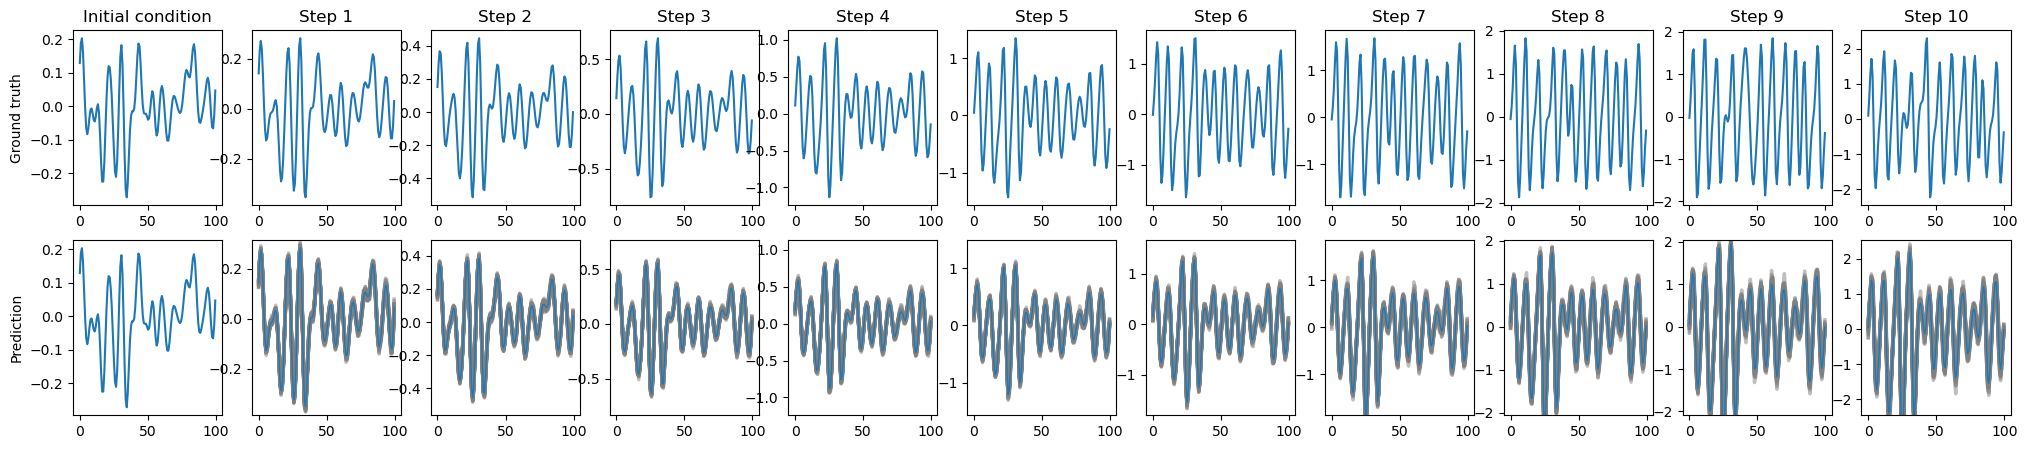

In [21]:
# Plot the autoregressive predictions
fig, axs = plt.subplots(2, t_steps+1, figsize=(25, 5))

# Truth
axs[0,0].plot(grid, t0[b,0].cpu().numpy())
axs[0,0].set_title("Initial condition")


axs[1,0].plot(grid, t0[b,0].cpu().numpy())
for t in range(t_steps):
    # Plot truth
    axs[0, t+1].plot(grid, trajectory[b,0,t].cpu().numpy(), label="Truth")
    axs[0,t+1].set_title(f"Step {t+1}")
    ylim = axs[0,t+1].get_ylim()

    for i in range(n_samples):
        pred_plot = full_array[b, 0, :, t, i]
        axs[1,t+1].plot(grid, pred_plot.cpu().numpy(), alpha=0.5, color="grey", lw = 2.5)
    # Plot mean
    pred_plot = full_array[b, 0, :, t].mean(axis=-1)
    axs[1,t+1].plot(grid, pred_plot.cpu().numpy(), label="Mean prediction", lw = 1)
    axs[1,t+1].set_ylim(ylim)



axs[0,0].set_ylabel("Ground truth")
axs[1,0].set_ylabel("Prediction")

# Mixed normal

In [22]:
ckpt_path = "../results/20250716_111601_debug/Datetime_20250716_111602_Loss_1D_KS_UNet_diffusion_.pt"
distributional_method = "mixednormal"

In [23]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim[-1]
        )

model = UNet_diffusion_mixednormal(
    backbone=backbone,
    d=1,
    target_dim = 1,
    n_components=10,
)
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)


/tmp/ipykernel_167931/952606495.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [24]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
)

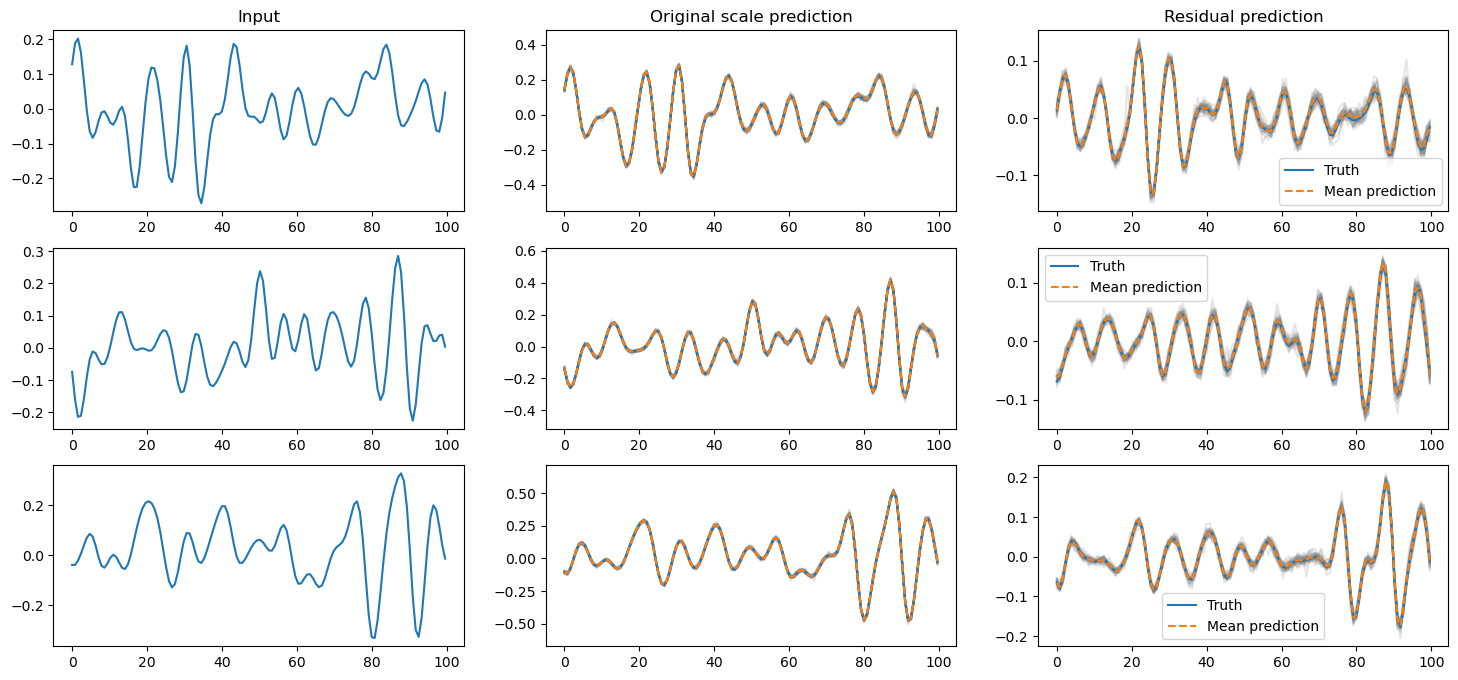

In [25]:
plot_predictions(input, target, pred, grid)

In [26]:
diffusion = DistributionalDiffusion(
    img_size=target.shape[1:], device=device, distributional_method=distributional_method, x_T_sampling_method=x_T_sampling_method
)
x = diffusion.sample_x_T((target.shape[0], *target_dim), pred)
t = (torch.ones(target.shape[0]) * 1000).long().to(device)
predicted_noise = model(x, t, input, pred = pred)

In [27]:
predicted_noise[0,0,0]

tensor([[-1.7739e+00,  3.9361e-01,  1.0169e-03],
        [-2.7480e+00,  3.6379e-01,  1.4960e-03],
        [-2.6619e+00,  6.8253e-02,  2.1276e-01],
        [-2.4190e+00,  2.2762e-01,  2.7335e-03],
        [-1.0991e+00,  1.8309e+00,  5.2223e-04],
        [-2.1197e+00,  3.4105e-02,  2.8532e-03],
        [-2.3849e+00,  4.5030e-02,  2.7860e-03],
        [-1.7106e+00,  4.3798e-01,  6.6512e-04],
        [-2.7387e+00,  1.6705e-01,  7.1513e-01],
        [-2.6298e+00,  7.7192e-02,  6.0038e-02]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [28]:
grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)

for i in range(n_samples):
    autoregressive_input = input.clone()
    pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
    for t in range(t_steps):
        pred = generate_diffusion_samples_low_dimensional(
            model=model,
            input = autoregressive_input,
            n_timesteps=n_timesteps,
            target_shape=target.shape,
            n_samples=1,
            distributional_method=distributional_method,
            x_T_sampling_method=x_T_sampling_method,
            cfg_scale=cfg_scale,
            noise_schedule="linear",
        )
        if t == 0:
            pred_array[...,t] = pred.squeeze(-1)+ t0
        else:
            pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

        if t == 1:
            autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
        elif t > 1:
            autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
    # Save
    full_array[...,i] = pred_array

Text(0, 0.5, 'Prediction')

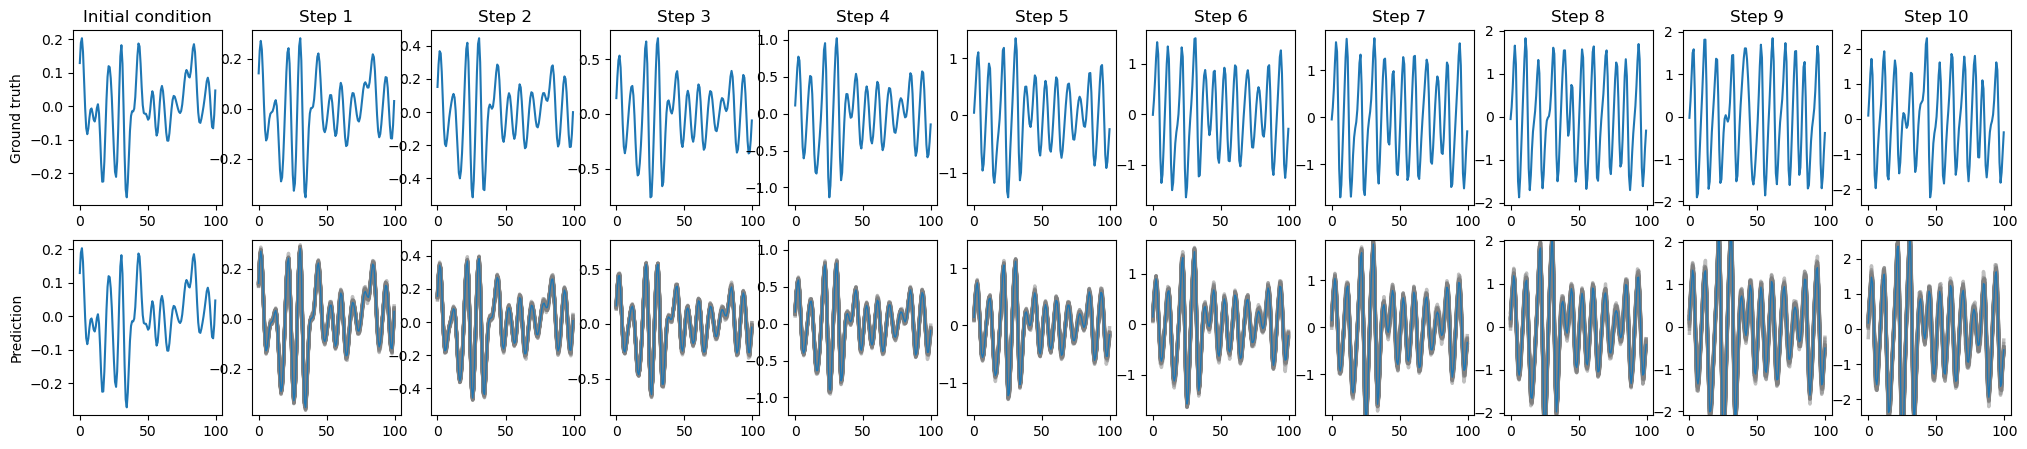

In [29]:
# Plot the autoregressive predictions
fig, axs = plt.subplots(2, t_steps+1, figsize=(25, 5))

# Truth
axs[0,0].plot(grid, t0[b,0].cpu().numpy())
axs[0,0].set_title("Initial condition")


axs[1,0].plot(grid, t0[b,0].cpu().numpy())
for t in range(t_steps):
    # Plot truth
    axs[0, t+1].plot(grid, trajectory[b,0,t].cpu().numpy(), label="Truth")
    axs[0,t+1].set_title(f"Step {t+1}")
    ylim = axs[0,t+1].get_ylim()

    for i in range(n_samples):
        pred_plot = full_array[b, 0, :, t, i]
        axs[1,t+1].plot(grid, pred_plot.cpu().numpy(), alpha=0.5, color="grey", lw = 2.5)
    # Plot mean
    pred_plot = full_array[b, 0, :, t].mean(axis=-1)
    axs[1,t+1].plot(grid, pred_plot.cpu().numpy(), label="Mean prediction", lw = 1)
    axs[1,t+1].set_ylim(ylim)



axs[0,0].set_ylabel("Ground truth")
axs[1,0].set_ylabel("Prediction")

# Sample

In [33]:
ckpt_path = "../results/20250716_111431_debug/Datetime_20250716_111432_Loss_1D_KS_UNet_diffusion_.pt"
distributional_method = "sample"

In [34]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=4,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim[-1]
        )



model = UNet_diffusion_sample(
    backbone=backbone,
    d=1,
    target_dim = 1,
    hidden_dim=64
)



dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(dict
    
)
model = model.to(device)


/tmp/ipykernel_167931/3853833390.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict = torch.load(ckpt_path, map_location=device)


In [35]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=50,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
)

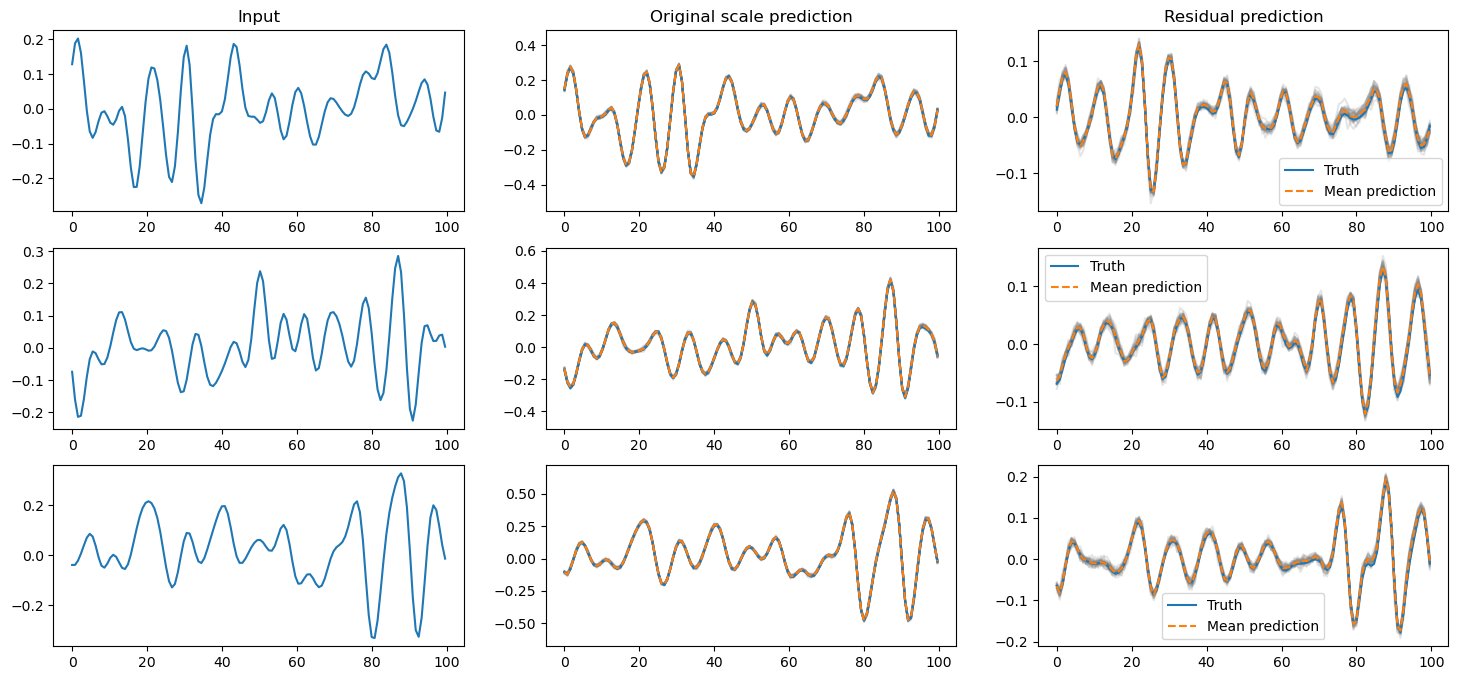

In [36]:
plot_predictions(input, target, pred, grid)

In [37]:

grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)

for i in range(n_samples):
    autoregressive_input = input.clone()
    pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
    for t in range(t_steps):
        pred = generate_diffusion_samples_low_dimensional(
            model=model,
            input = autoregressive_input,
            n_timesteps=n_timesteps,
            target_shape=target.shape,
            n_samples=1,
            distributional_method=distributional_method,
            x_T_sampling_method=x_T_sampling_method,
            cfg_scale=cfg_scale,
            noise_schedule="linear",
        )
        if t == 0:
            pred_array[...,t] = pred.squeeze(-1)+ t0
        else:
            pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

        if t == 1:
            autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
        elif t > 1:
            autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
    # Save
    full_array[...,i] = pred_array

Text(0, 0.5, 'Prediction')

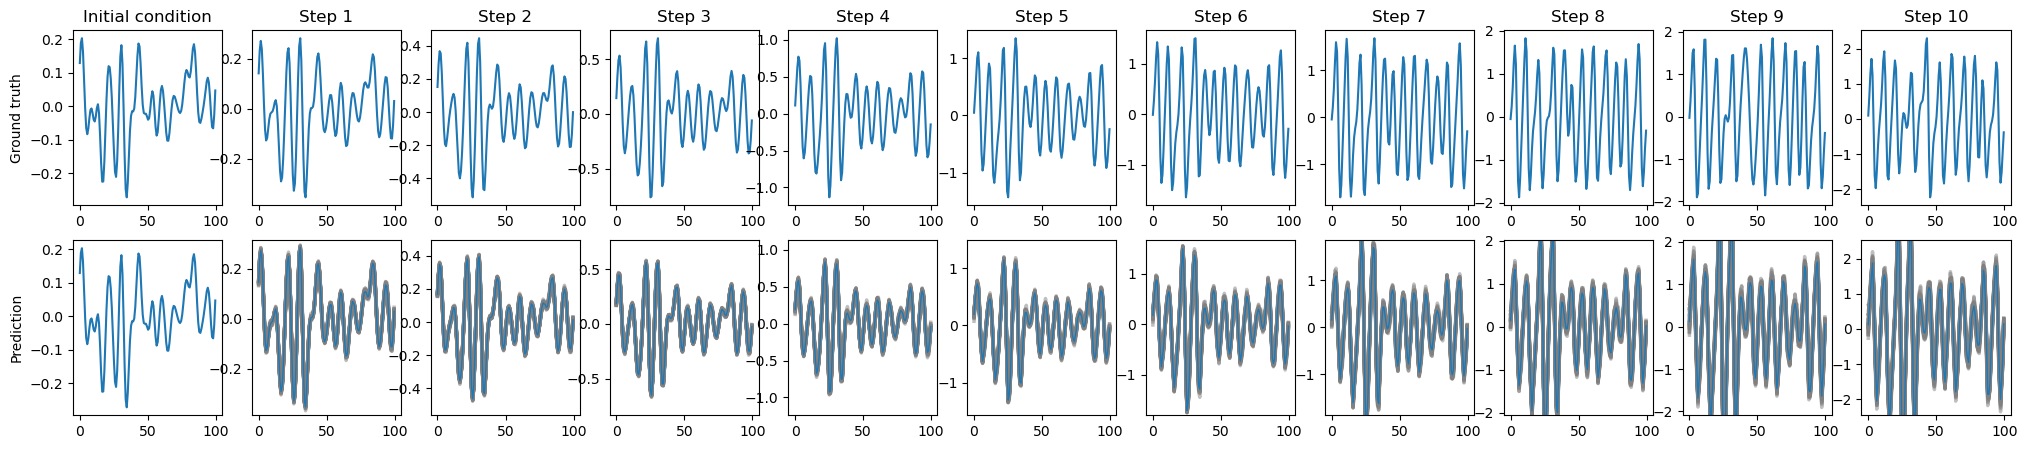

In [38]:
# Plot the autoregressive predictions
fig, axs = plt.subplots(2, t_steps+1, figsize=(25, 5))

# Truth
axs[0,0].plot(grid, t0[b,0].cpu().numpy())
axs[0,0].set_title("Initial condition")


axs[1,0].plot(grid, t0[b,0].cpu().numpy())
for t in range(t_steps):
    # Plot truth
    axs[0, t+1].plot(grid, trajectory[b,0,t].cpu().numpy(), label="Truth")
    axs[0,t+1].set_title(f"Step {t+1}")
    ylim = axs[0,t+1].get_ylim()

    for i in range(n_samples):
        pred_plot = full_array[b, 0, :, t, i]
        axs[1,t+1].plot(grid, pred_plot.cpu().numpy(), alpha=0.5, color="grey", lw = 2.5)
    # Plot mean
    pred_plot = full_array[b, 0, :, t].mean(axis=-1)
    axs[1,t+1].plot(grid, pred_plot.cpu().numpy(), label="Mean prediction", lw = 1)
    axs[1,t+1].set_ylim(ylim)



axs[0,0].set_ylabel("Ground truth")
axs[1,0].set_ylabel("Prediction")

# Multivariate normal

In [45]:
ckpt_path = "../results/20250716_180104_debug/Datetime_20250716_180104_Loss_1D_KS_UNet_diffusion_.pt"
distributional_method = "mvnormal"

In [46]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim[-1]
        )

#backbone.conditioning_projection = torch.nn.Identity()

model = UNet_diffusion_mvnormal(
    backbone=backbone,
    d=1,
    target_dim = 1,
    domain_dim = target_dim[1:],
    rank = 10,
    method = "lora"
)

dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(dict
    
)
model = model.to(device)


/tmp/ipykernel_167931/732789396.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict = torch.load(ckpt_path, map_location=device)


In [47]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=50,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
)

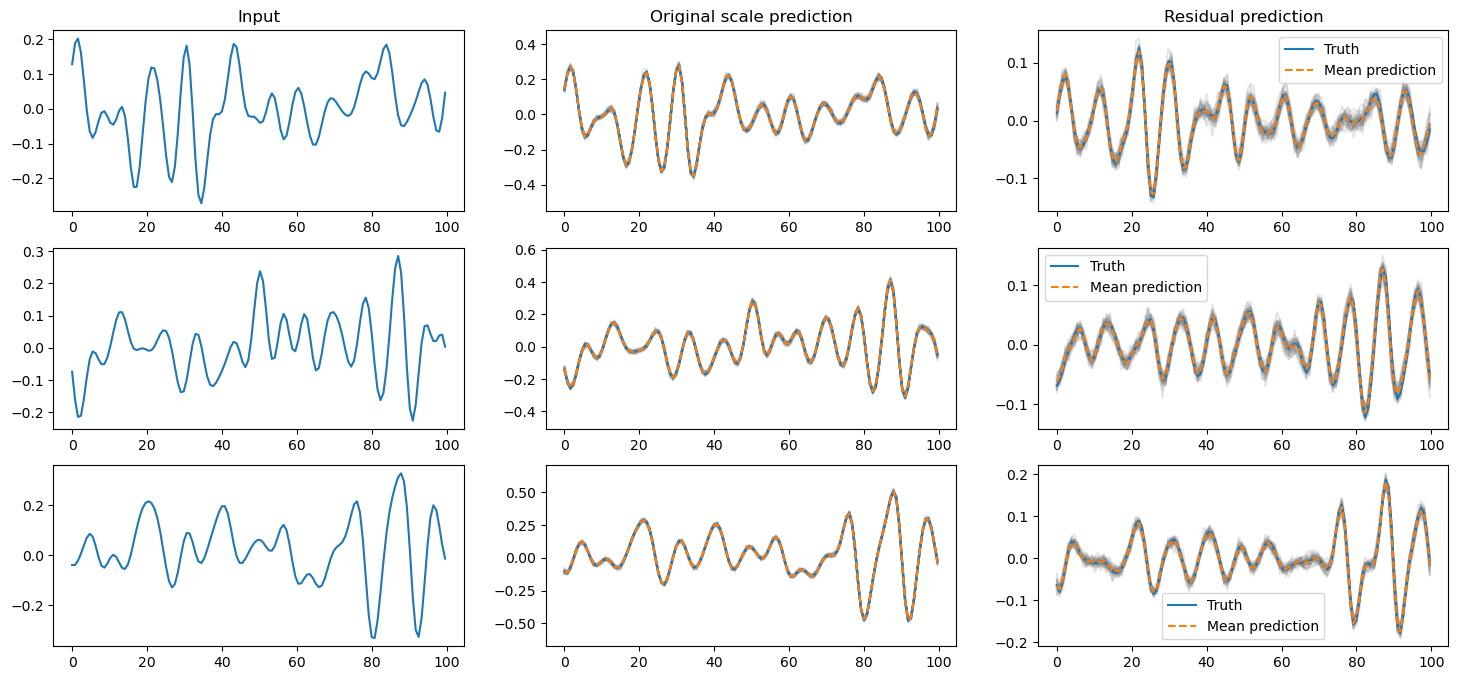

In [48]:
plot_predictions(input, target, pred, grid)

In [49]:
grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)

for i in range(n_samples):
    autoregressive_input = input.clone()
    pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
    for t in range(t_steps):
        pred = generate_diffusion_samples_low_dimensional(
            model=model,
            input = autoregressive_input,
            n_timesteps=n_timesteps,
            target_shape=target.shape,
            n_samples=1,
            distributional_method=distributional_method,
            x_T_sampling_method=x_T_sampling_method,
            cfg_scale=cfg_scale,
            noise_schedule="linear",
        )
        if t == 0:
            pred_array[...,t] = pred.squeeze(-1)+ t0
        else:
            pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

        if t == 1:
            autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
        elif t > 1:
            autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
    # Save
    full_array[...,i] = pred_array

Text(0, 0.5, 'Prediction')

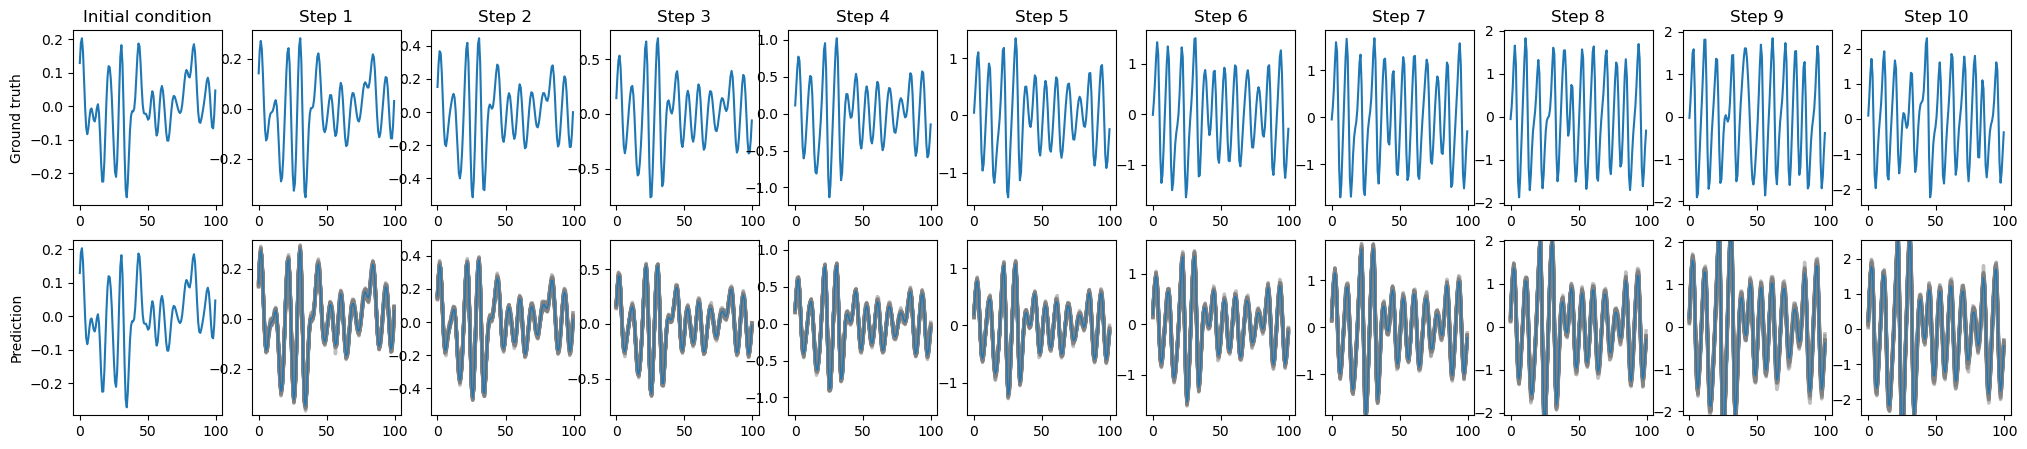

In [50]:
# Plot the autoregressive predictions
fig, axs = plt.subplots(2, t_steps+1, figsize=(25, 5))

# Truth
axs[0,0].plot(grid, t0[b,0].cpu().numpy())
axs[0,0].set_title("Initial condition")


axs[1,0].plot(grid, t0[b,0].cpu().numpy())
for t in range(t_steps):
    # Plot truth
    axs[0, t+1].plot(grid, trajectory[b,0,t].cpu().numpy(), label="Truth")
    axs[0,t+1].set_title(f"Step {t+1}")
    ylim = axs[0,t+1].get_ylim()

    for i in range(n_samples):
        pred_plot = full_array[b, 0, :, t, i]
        axs[1,t+1].plot(grid, pred_plot.cpu().numpy(), alpha=0.5, color="grey", lw = 2.5)
    # Plot mean
    pred_plot = full_array[b, 0, :, t].mean(axis=-1)
    axs[1,t+1].plot(grid, pred_plot.cpu().numpy(), label="Mean prediction", lw = 1)
    axs[1,t+1].set_ylim(ylim)



axs[0,0].set_ylabel("Ground truth")
axs[1,0].set_ylabel("Prediction")